In [1]:
import pandas as pd
pd.set_option("display.max_rows", None, "display.max_columns", None)#to display complete dataframe
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error 

In [2]:
#Read the 'indice de cartera vencida' file, and set the col 0 ('Fecha') be the dataframe index.
indice_df = pd.read_excel('icv_mensual.xlsx', index_col=0)

#Resample the ICV_cartera_total into quarterly periods, so we get the average icv of each three 
#months; this is done because the predictor variables are all in quarters frequency, so the 
#predictors and the labels must to match. 
quarterly_resampled_indice_df = indice_df.ICV_cartera_total.resample('Q').mean()

### EXPLORATORY DATA ANALYSIS WITH PANDAS AND NUMPY

In [4]:
#read the 'variables' dataset
data = pd.read_excel('variables_macro_trimestral.xlsx', index_col=0)
#Remove the first 3 and the last rows, to correctly match with the ICV data
variables_df = data.iloc[3:-1].copy()

In [5]:
variables_df

,Desempleo,IPC,TRM,Exportaciones,Importaciones,PIB
Fecha,,,,,,
2001-12-01,0.166253,NaN,2306.900000,NaN,NaN,NaN
2002-03-01,0.190028,NaN,2282.330000,NaN,NaN,NaN
2002-06-01,0.177497,NaN,2364.250000,NaN,NaN,NaN
2002-09-01,0.179465,NaN,2751.230000,NaN,NaN,NaN
2002-12-01,0.157456,NaN,2814.890000,NaN,NaN,NaN
2003-03-01,0.177929,51.51,2959.010000,NaN,NaN,NaN
2003-06-01,0.169987,52.33,2826.950000,NaN,NaN,NaN
2003-09-01,0.169685,52.53,2840.080000,NaN,NaN,NaN
2003-12-01,0.146136,53.07,2807.200000,NaN,NaN,NaN


In [6]:
#Merge the labels (ICV) and the predictors (variables) into a signel dataframe.
variables_df['icv_cartera_total'] = list(quarterly_resampled_indice_df)
#add an incremental column number to see how the variables change with transcurred time
variables_df['count'] = range(0, len(variables_df.index))
#Let's check the column datatypes 
variables_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 76 entries, 2001-12-01 to 2020-09-01
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Desempleo          76 non-null     float64
 1   IPC                71 non-null     float64
 2   TRM                76 non-null     float64
 3   Exportaciones      47 non-null     float64
 4   Importaciones      47 non-null     float64
 5   PIB                63 non-null     float64
 6   icv_cartera_total  76 non-null     float64
 7   count              76 non-null     int32  
dtypes: float64(7), int32(1)
memory usage: 5.0 KB


In [7]:
#Check for null values, and how many per column
variables_df.isnull().sum()

Desempleo             0
IPC                   5
TRM                   0
Exportaciones        29
Importaciones        29
PIB                  13
icv_cartera_total     0
count                 0
dtype: int64

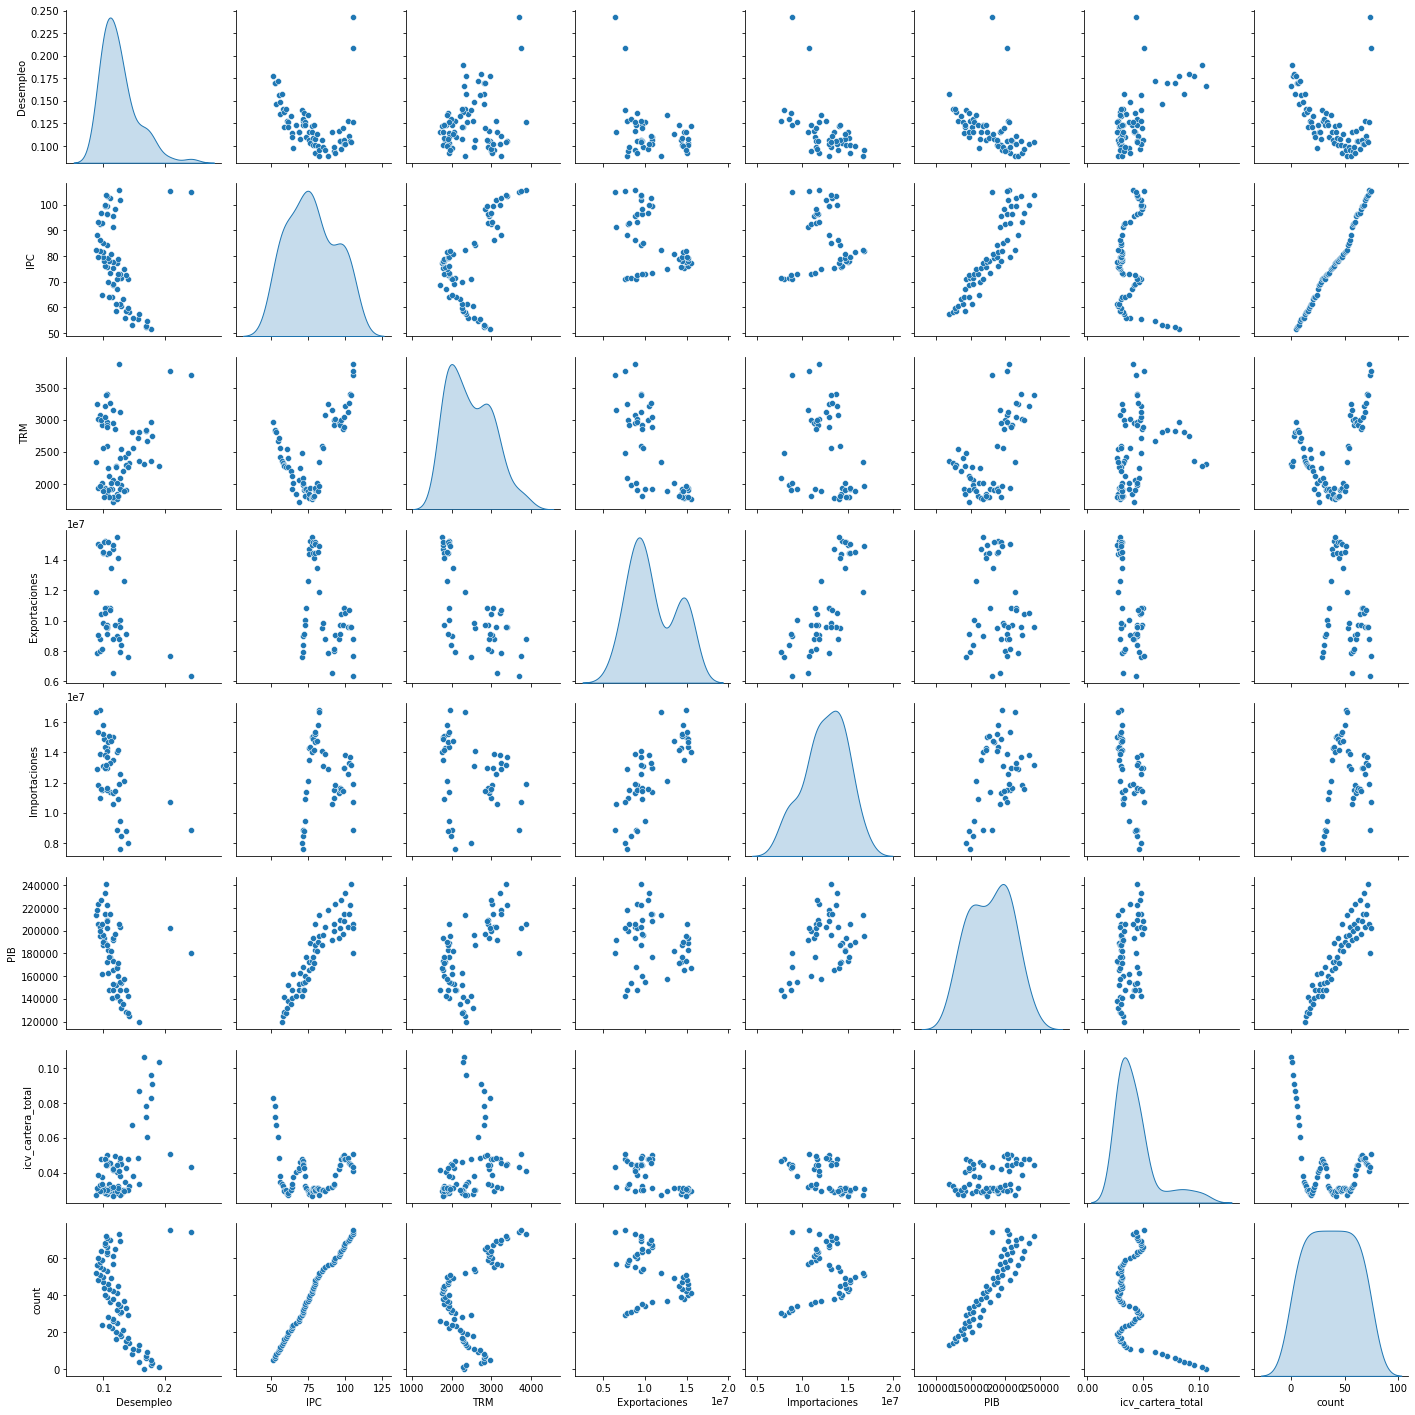

In [8]:
#Plot for correlations between variables
sns.pairplot(variables_df, diag_kind = 'kde')

#### Linear regression imputation

In [9]:
#This function fills the null values of the columns which has high correlation with a column
#which does not have null values
def regression_imputer(dataframe, column_name):
    #dataframe must has a column called 'count' which is only a consecutive number of rows.
    df = dataframe.copy()  
    #regression between count and 'column_name'
    #The following code generates a df with the neccesary data to train the regression model, 
    #excluding the null values.
    model_data = df[['count', f'{column_name}']][df[f'{column_name}'].notnull()]
    #create x and y arrays, we must reshape it because LinearRegression() object only accepts array 
    #like inputs
    x = model_data['count'].values.reshape(-1, 1)
    y = model_data[f'{column_name}'].values.reshape(-1, 1)
    #Create the Linear Regression model to estimate the missing data
    regression_model = linear_model.LinearRegression()
    #fit the model
    regression_model.fit(X = x, y = y)
    #generate the x values to be predicted (the 'count' values), the following line extracts from 
    #the 'count' column the values where in 'column_name' are nulls, so it extract the X's needed to
    #be preddicted. 
    x_to_predict = df['count'][df[f'{column_name}'].isnull()].values.reshape(-1,1)
    #Make the predictions
    predictions = regression_model.predict(x_to_predict)
    #We need to transform the predictions array into a numeric list.
    predictions = [float(i) for i in predictions] 
    #From the dataframe, select all the null positions in the column, and then replace them by the 
    #new predictions
    df[f'{column_name}'][df[f'{column_name}'].isnull()] = predictions
    return df


In [10]:
#The following list takes the column names which are going to be imputed with regression technique.
columns_to_regression_imputer = ['IPC', 'PIB']

#Create a copy of the dataframe with the null columns
imputed_df = variables_df.copy()

#apply the regression imputer to the columns that need it 
for column in columns_to_regression_imputer:

    imputed_df = regression_imputer(imputed_df, column)


c:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [11]:
imputed_df

,Desempleo,IPC,TRM,Exportaciones,Importaciones,PIB,icv_cartera_total,count
Fecha,,,,,,,,
2001-12-01,0.166253,46.628820,2306.900000,NaN,NaN,110358.064962,0.106365,0
2002-03-01,0.190028,47.397941,2282.330000,NaN,NaN,111896.525372,0.103204,1
2002-06-01,0.177497,48.167062,2364.250000,NaN,NaN,113434.985782,0.095999,2
2002-09-01,0.179465,48.936183,2751.230000,NaN,NaN,114973.446193,0.091033,3
2002-12-01,0.157456,49.705304,2814.890000,NaN,NaN,116511.906603,0.086660,4
2003-03-01,0.177929,51.510000,2959.010000,NaN,NaN,118050.367014,0.082609,5
2003-06-01,0.169987,52.330000,2826.950000,NaN,NaN,119588.827424,0.078304,6
2003-09-01,0.169685,52.530000,2840.080000,NaN,NaN,121127.287835,0.071981,7
2003-12-01,0.146136,53.070000,2807.200000,NaN,NaN,122665.748245,0.067244,8


#### Set aside the test dataset

In [78]:
#Save the predictors in 'x' and the labels in 'y'
x = imputed_df.drop('icv_cartera_total', axis = 1)
y = list(quarterly_resampled_indice_df)

In [81]:
#create the train and test data
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(x, y, random_state = 42)

In [89]:
#Let's impute the columns 'Exportaciones' and 'Importaciones' with their respective means
from sklearn.impute import SimpleImputer
imputer = SimpleImputer()
imputed_train_x = pd.DataFrame(imputer.fit_transform(train_x))
imputed_test_x = pd.DataFrame(imputer.transform(test_x)) #Only we use .transform() because this is 
#out_sample data.

#imputation removed col names, put them back
imputed_train_x.columns = train_x.columns
imputed_test_x.columns = test_x.columns

#### Selecting and training Machine Learning models

In [155]:
#RANDOM FOREST
model = RandomForestRegressor(random_state=1)
model.fit(imputed_train_x, train_y)

predictions = model.predict(imputed_test_x)
print(mean_absolute_error(test_y, predictions))

0.003042513821923457


In [156]:
#LINEAR REGRESSION
linear_regressor = linear_model.LinearRegression()
linear_regressor.fit(imputed_train_x, train_y)

linear_regressor_predictions = linear_regressor.predict(imputed_test_x)
print(mean_absolute_error(test_y, linear_regressor_predictions))

pd.DataFrame(linear_regressor.coef_, imputed_train_x.columns, columns = ['coef'])\
.sort_values(by = 'coef', ascending = False)

0.009224261010692352


,coef
Desempleo,2.766213e-01
IPC,1.871988e-03
TRM,1.577539e-05
PIB,4.932311e-07
Exportaciones,2.435551e-09
Importaciones,-1.525425e-09
count,-2.539225e-03


In [157]:
#DECISION TREE


decision_tree_regressor = DecisionTreeRegressor(random_state=1)
decision_tree_regressor.fit(imputed_train_x, train_y)
decision_tree_regressor_predictions = decision_tree_regressor.predict(imputed_test_x)
print(mean_absolute_error(test_y, decision_tree_regressor_predictions))

0.0031814963749280424


In [158]:
#THIS SINGLE CYCLE REPLACES THE 3 SECTIONS FOR MODELS, JUST ADD THE IMPORTS AT THE BEGINING OF THE 
#NOTEBOOK
models = [RandomForestRegressor(random_state=1), linear_model.LinearRegression(), DecisionTreeRegressor(random_state=1)]
errors = []

for model in models: 
    
    predictor = model 
    predictor.fit(imputed_train_x, train_y)
    predictions = predictor.predict(imputed_test_x)
    errors.append(mean_absolute_error(test_y, predictions))

pd.DataFrame(errors, ['RandomForest', 'Linear_Regression', 'DecisionTree'], columns = ['error'])
    
    


,error
RandomForest,0.003043
Linear_Regression,0.009224
DecisionTree,0.003181
